## Prediction of ETH Price using SBi-LSTM

In [1]:
# PR
# 1. Jelaskan perbedaan antara FeedForward & BackForward pada Neural Network!
# 2. Jelaskan perbedaan Stacked & Bidirectional pada Neural Network!
# 3. Jelaskan pengertian dari metode RNN, LSTM, dan GRU!
# 4. Jelaskan apakah bisa konsep Stacked dan Bidirectional dipadukan dengan Metode LSTM? Mengapa demikian?? 
# 5. Jelaskan apa yang dimaksud dengan Hyperparameter Grid-Search CV

In [2]:
# Library Get Dataset
import yfinance as yf

# Lib Manipulations : Time
import time as tm

# Lib Load Dataset
import numpy as np
import pandas as pd

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 1000)

# Lib Load Data Visualization
from matplotlib.dates import DateFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Lib Load Preprocessing Data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Lib Load Neural Networks
import tensorflow as tf
from keras.layers import LSTM
from keras.layers import GRU

from tensorflow.python.keras.layers import SimpleRNNCell
from tensorflow.python.keras.layers import RNN
from tensorflow.keras.layers import LSTM, SimpleRNNCell

# Lib Evaluate Models
import scipy.stats as sc
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [3]:
# Set Random Number
import random as rm
rm.seed(1234)

# Set Random Number
import numpy as np
np.random.seed(1234)

# Set Random Number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Data Acquisition

In [4]:
# Set Stock Price
ticker = "ETH-USD"

# Get Dataset from yfinance
df = yf.Ticker(ticker).history(start="2015-01-01", end="2024-11-30").reset_index()

# Set Feature OHLC
df = df[["Date", "Open", "High", "Low",	"Close"]]
print(np.round(df,2))

                          Date     Open     High      Low    Close
0    2017-11-09 00:00:00+00:00   308.64   329.45   307.06   320.88
1    2017-11-10 00:00:00+00:00   320.67   324.72   294.54   299.25
2    2017-11-11 00:00:00+00:00   298.59   319.45   298.19   314.68
3    2017-11-12 00:00:00+00:00   314.69   319.15   298.51   307.91
4    2017-11-13 00:00:00+00:00   307.02   328.42   307.02   316.72
...                        ...      ...      ...      ...      ...
2573 2024-11-25 00:00:00+00:00  3364.60  3545.28  3304.09  3413.54
2574 2024-11-26 00:00:00+00:00  3412.95  3461.29  3255.54  3326.52
2575 2024-11-27 00:00:00+00:00  3326.03  3687.01  3303.57  3657.25
2576 2024-11-28 00:00:00+00:00  3656.61  3664.88  3531.87  3579.81
2577 2024-11-29 00:00:00+00:00  3579.91  3647.26  3538.45  3593.49

[2578 rows x 5 columns]


### 2. Exploration Data Analysis (EDA)

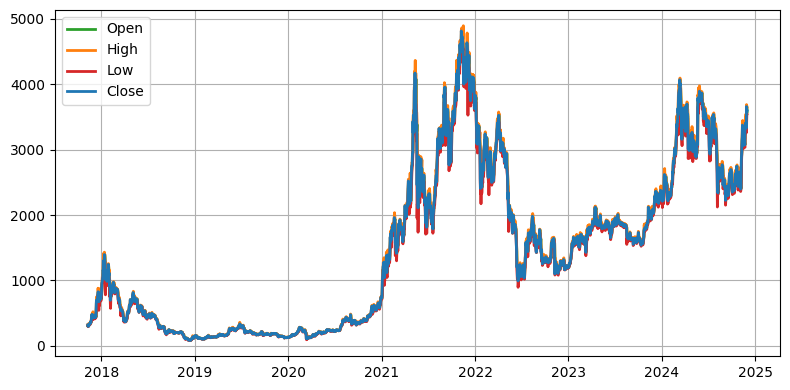

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["Date"], df["Open"], color="tab:green", label="Open", linewidth=2)
ax.plot(df["Date"], df["High"], color="tab:orange", label="High", linewidth=2)
ax.plot(df["Date"], df["Low"], color="tab:red", label="Low", linewidth=2)
ax.plot(df["Date"], df["Close"], color="tab:blue", label="Close", linewidth=2)

ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)


plt.tight_layout()
plt.show()

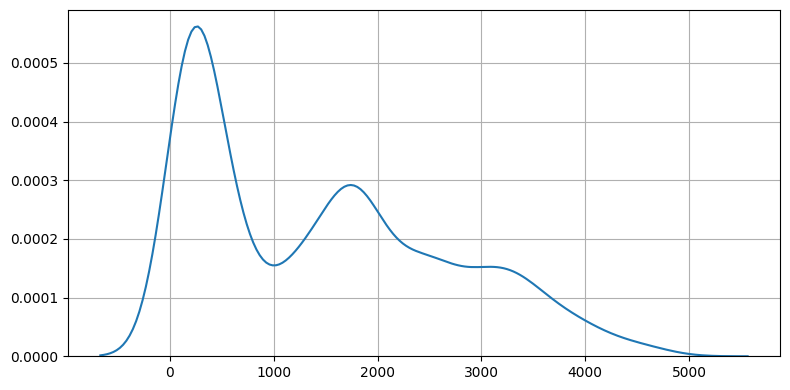

In [6]:
fig, ax = plt.subplots(figsize=(8, 4))

sns.kdeplot(data=df, x='Open', bw_adjust=1)

# ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
# ax.legend(loc="best")
ax.grid(True)


plt.tight_layout()
plt.show()

### 3. Data Preprocessing

In [7]:
# Choose Feature : Close Price
data = df.filter(["Close"])
data = data.values

In [8]:
# Show Result Feature Selection
np.round(data[:5],6)


array([[320.884003],
       [299.252991],
       [314.681   ],
       [307.90799 ],
       [316.716003]])

In [9]:
# Show Dimension Data
print("Dimension of Dataset : "+str(data.shape))

Dimension of Dataset : (2578, 1)


- Normalization Data with MinMaxScaler

In [10]:
# Normalize Features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.array(data).reshape(-1,1))

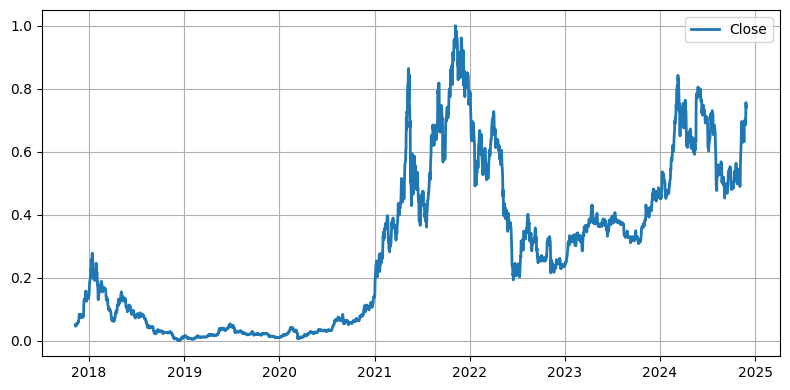

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(df["Date"], scaled, color="tab:blue", label="Close", linewidth=2)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(loc="best")
ax.grid(True)

plt.tight_layout()
plt.show()

### 4. Splitting Data

In [12]:
# Train & Test Data
train_data, test_data = train_test_split(scaled, train_size=0.8, test_size=0.2, shuffle=False)

# Check Result Splitting
print("Dimension of Data Train : "+str(train_data.shape))
print("Dimension of Data Test  : "+str(test_data.shape))

Dimension of Data Train : (2062, 1)
Dimension of Data Test  : (516, 1)


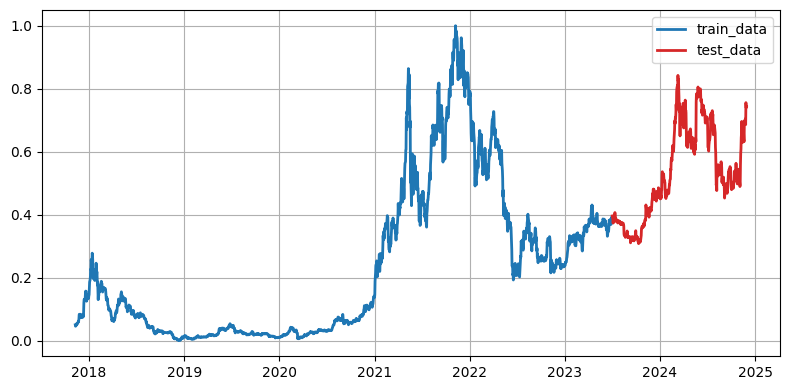

In [13]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    df["Date"].iloc[0:len(train_data)], train_data, color="tab:blue", label="train_data", linewidth=2
)
ax.plot(
    df["Date"].iloc[len(train_data):], test_data, color="tab:red", label="test_data", linewidth=2
)

ax.set_title('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.legend(loc="best")
ax.grid(True)

plt.tight_layout()
plt.show()

### 5. Supervised Learning on Time Series

In [14]:
# Function for Supervised Learning
def create_dataset(look_back, dataset):

    # Declare Variable X & Y
    dataX = []
    dataY = []

    # For loop for create supervised learning
    for i in range(look_back, len(dataset)):
        dataX.append(dataset[i-look_back:i, 0])
        dataY.append(dataset[i, 0])

    # Return value X and Y
    return np.array(dataX), np.array(dataY)

In [15]:
# Supervised Learning
x_train, y_train = create_dataset(60, train_data)

# Result of Supervised Learning
print("Dimension of XTrain : "+str(x_train.shape))
print("Dimension of YTrain : "+str(y_train.shape))

Dimension of XTrain : (2002, 60)
Dimension of YTrain : (2002,)


In [16]:
# Supervised Learning
x_test, y_test = create_dataset(60, test_data)

# Result of Supervised Learning
print("Dimension of XTest : "+str(x_test.shape))
print("Dimension of YTest : "+str(y_test.shape))

Dimension of XTest : (456, 60)
Dimension of YTest : (456,)


In [17]:
# Reshape Input to be Sample, Time Step, and Feature
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Result of Input LSTM
print("Dimension of XTrain : "+str(x_train.shape))
print("Dimension of YTrain : "+str(y_train.shape))

# Result of Input LSTM
print("Dimension of XTest  : "+str(x_test.shape))
print("Dimension of YTest  : "+str(y_test.shape))

Dimension of XTrain : (2002, 60, 1)
Dimension of YTrain : (2002,)
Dimension of XTest  : (456, 60, 1)
Dimension of YTest  : (456,)


### 6. Implementation of Neural Network using Tensorflow

In [18]:
# PR : 
# 1. Jelaskan apa yang dimaksud dengan Neural Network
# 2. Jelaskan tentang Input Layer, Hidden Layer, dan Output Layer
# 3. Jelaskan apa yang dimaksud LSTM
# 4. Jelaskan pengaruh setting Optimizer, Batch Size, dan Epoch ke dalam Model LSTM
# 5. Jelaskan perbedaan antara Grid Search, Random Search, dan Bayesian Search untuk setting parameter LSTM

In [19]:
# Measuring Execution Time
start_time = tm.time()

In [20]:
# Set Parameter Tuning
optimizers = "adamax"        # PR 6. Jelaskan perbedaan antara adamax, adam, rmsprop, SGD
batch_size = 32              # PR 7. Jelaskan pengaruh jumlah Batch Size 4, 8, 16, 32 ke Model LSTM
epoch      = 25              # PR 8. Jelaskan pengaruh jumlah Epoch 50, 75, 100 ke Model LSTM
# 9. Tentukan parameter untuk membuat prediksi ETH menjadi bagus!


In [21]:
# PR
# Buat Arsitektur SBi-LSTM yang bisa membuat prediksi ETH menjadi bagus

# 1. Architecture LSTM

tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1))),
    tf.keras.layers.Bidirectional(LSTM(units=50, return_sequences=False)),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(1),
    
])
def build_lstm_model(input_data, neurons, activ_func='tanh', loss='mse', optimizer='optimizers'):
    tf.keras.layers.Activation(activ_func),
    tf.keras.layers.RNN(cell=[SimpleRNNCell(128), SimpleRNNCell(256), SimpleRNNCell(128)])
    tf.keras.compile(loss=loss, optimizer=optimizer)

class LSTM(tf.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = tf.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = tf.Dropout(0.2)
        self.fc = tf.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

In [22]:
# 2. Compile Models
model.compile(optimizer=optimizers, loss="mean_squared_error")

In [23]:
# 3. Fitting Models
history = model.fit(
    x=x_train, y=y_train,
    batch_size=batch_size, epochs=epoch, verbose=1,
    validation_data=(x_test, y_test),
    shuffle=False, use_multiprocessing=True,
)

Epoch 1/25
63/63 [==============================] - 16s 96ms/step - loss: 0.0155 - val_loss: 0.0110
Epoch 2/25
63/63 [==============================] - 4s 65ms/step - loss: 0.0084 - val_loss: 0.0034
Epoch 3/25
63/63 [==============================] - 4s 70ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 4/25
63/63 [==============================] - 5s 77ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 5/25
63/63 [==============================] - 4s 71ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 6/25
63/63 [==============================] - 4s 67ms/step - loss: 0.0026 - val_loss: 0.0065
Epoch 7/25
63/63 [==============================] - 4s 67ms/step - loss: 0.0023 - val_loss: 0.0064
Epoch 8/25
63/63 [==============================] - 4s 68ms/step - loss: 0.0022 - val_loss: 0.0080
Epoch 9/25
63/63 [==============================] - 4s 69ms/step - loss: 0.0022 - val_loss: 0.0088
Epoch 10/25
63/63 [==============================] - 4s 69ms/step - loss: 0.0022 - val_loss: 0.0098
Epoch 11

In [24]:
# 4. Model Predictions
predictions = model.predict(x_test, verbose=0)

In [25]:
# Measuring Execution Time
end_time = tm.time()

# Calculating the Total Execution Time
execution_time = end_time - start_time

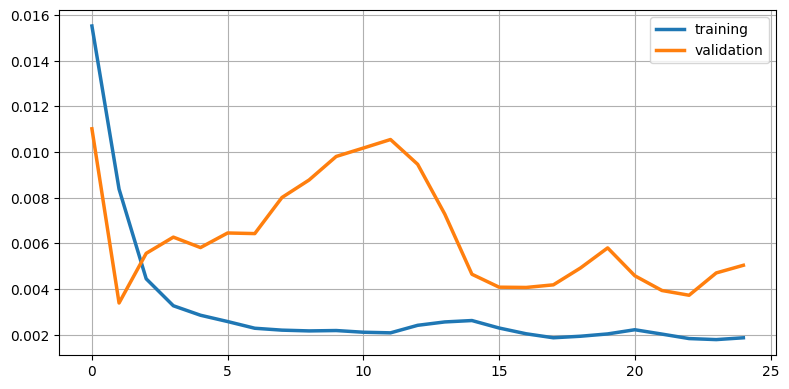

In [26]:
# Create Figure with Matplotlib
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(history.epoch, history.history["loss"], label="training", linewidth=2.5)
ax.plot(history.epoch, history.history["val_loss"], label="validation", linewidth=2.5)

# Set Labels
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# Return Values
plt.tight_layout()
plt.show()

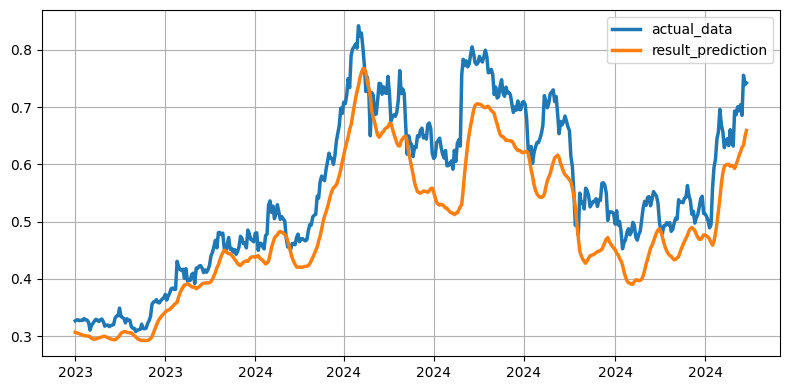

In [27]:
# Create Figure with Matplotlib
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df[["Date"]].iloc[len(y_train)+120:], y_test,
        label="actual_data", linewidth=2.5)
ax.plot(df[["Date"]].iloc[len(y_train)+120:], predictions,
        label="result_prediction", linewidth=2.5)

# Set Labels
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.set_title("", fontsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("", fontsize=12)
ax.legend(loc="best")
ax.grid(True)

# Return Values
plt.tight_layout()
plt.show()

### 7. Model Evaluation

In [28]:
# Function
def evaluate_models(ytrue, ypred):

    # Calculate R & MAPE
    r    = sc.mstats.pearsonr(ytrue,ypred)[0]
    mape = mean_absolute_percentage_error(ytrue,ypred)

    # Return Values
    return np.round(r,4), np.round(mape,4)

In [29]:
# Calculate Error
r, mape = evaluate_models(y_test, predictions)
print("r    : "+str(np.round(r, 4)))
print("mape : "+str(np.round(mape, 4)))
print("Time : "+"{:,.2f}".format(execution_time))

# Rentang nilai r dari 0 sampai 1, mendekati 0 artinya modelnya jelek, mendekati 1 berarti bagus
# Sedangkan rentang nilai mape, dari 0% sampai 100%, semakin mendekati 0 artinya modelnya semakin bagus, mendekati 100 artinya semakin jelek

r    : 0.9665
mape : 0.1057
Time : 124.41
